# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

from helpers import to_dataset
from model.randomized_prior_nn import RandomizedPrioNet

# Get some multidimensional data

In [3]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

batch_size = 256

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

ds_train = to_dataset(X_train, y_train, batch_size=batch_size)
ds_val = to_dataset(X_val, y_val, batch_size=batch_size)
    
print(f"train size: {len(ds_train.unbatch())}")
print(f"val size: {len(ds_val.unbatch())}")
print(f"test size: {len(X_test)}")

train size: 14848
val size: 1536
test size: 4128


2023-08-03 13:41:13.325441: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-08-03 13:41:13.325465: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-08-03 13:41:13.325469: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-08-03 13:41:13.325497: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-03 13:41:13.325512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Train model

In [4]:
model = RandomizedPrioNet(
    num_hidden_prior=1,
    dim_hidden_prior=16,
    num_hidden_encoder=2,
    dim_hidden_encoder=64,
    dropout_encoder=0.2,
    num_subnetworks=20,
    prior_scale=1.0,
)

tf.keras.backend.clear_session()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
model.compile(optimizer=optimizer, loss=loss)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, mode="min", verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1),
]

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=20,
    callbacks=callbacks,
)

Epoch 1/20


2023-08-03 13:41:15.804970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 1.6917

2023-08-03 13:41:23.168059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 10s 88ms/step - loss: 1.6917 - val_loss: 1.3101 - lr: 0.0100
Epoch 2/20
58/58 [==============================] - 4s 65ms/step - loss: 0.8306 - val_loss: 0.9444 - lr: 0.0100
Epoch 3/20
58/58 [==============================] - 4s 68ms/step - loss: 0.6949 - val_loss: 0.6943 - lr: 0.0100
Epoch 4/20
58/58 [==============================] - 4s 65ms/step - loss: 0.6783 - val_loss: 0.6920 - lr: 0.0100
Epoch 5/20
58/58 [==============================] - 4s 63ms/step - loss: 0.6339 - val_loss: 0.6271 - lr: 0.0100
Epoch 6/20
58/58 [==============================] - 4s 63ms/step - loss: 0.5978 - val_loss: 0.5979 - lr: 0.0100
Epoch 7/20
58/58 [==============================] - 4s 65ms/step - loss: 0.5752 - val_loss: 0.6177 - lr: 0.0100
Epoch 8/20
58/58 [==============================] - 4s 64ms/step - loss: 0.5777 - val_loss: 0.5895 - lr: 0.0100
Epoch 9/20
58/58 [==============================] - 4s 65ms/step - loss: 0.5470 - val_loss: 0.5456 - lr: 0.0100
Ep

In [18]:
y_pred, y_pred_intervals = model.predict(X_test, batch_size=batch_size)

17/17 [==============================] - 0s 12ms/step


In [19]:
y_pred_intervals

array([[3.9378812, 4.1270485],
       [2.5395484, 2.6256328],
       [1.2865691, 1.3988476],
       ...,
       [0.9186543, 1.0284537],
       [2.176607 , 2.3298662],
       [2.1017737, 2.1907783]], dtype=float32)

Text(0, 0.5, 'prediction (+/- 95% confidence)')

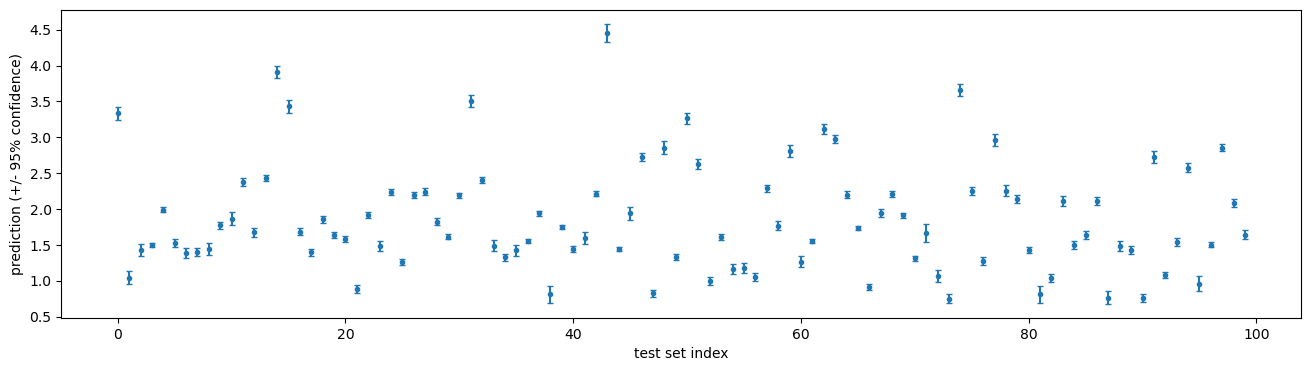

In [21]:
n_sample = 100
inds = np.random.choice(range(y_pred.shape[0]), n_sample)
y_err = y_pred_intervals[:, 1] - y_pred[:]

fig, ax = plt.subplots(figsize=(16, 4))
ax.errorbar(x=range(n_sample), y=y_pred[inds], yerr=y_err[inds], fmt=".", capsize=2)
ax.set_xlabel("test set index")
ax.set_ylabel("prediction (+/- 95% confidence)")